In [354]:
import pandas as pd 
from tensorly.decomposition import tucker

import matplotlib.pyplot as plt 


In [355]:
df = pd.read_csv('resources/data/taz.view_moveandchill.csv',index_col='id')
COLUMN_MAP =  {
    'objectid'      : 'ID',
    'sensor_eui'    : 'sensor_ID',
    'zeitpunkt'     : 'timestamp',
    'temperature'   : 'temperature',
    'humidity'      : 'humidity',
    'latitude'      : 'latitude', 
    'longitude'     : 'longitude',
    'noise'         : 'noise',
    'sit'           : "% occupancy"   # every 15-30 mins the sensor resets and checks occupancy 
    
}
df.rename(columns=COLUMN_MAP,inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H%M%S')
# df['timestamp'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds().astype(int)
df = df.sort_values(by='timestamp',ascending=True)
df['sensor_ID'].value_counts()

sensor_ID
0080E115003BC1DF    2564
0080E115003BC812    2560
0080E115003BCF64    2556
0080E115003BDA59    2524
0080E115003BC8D7    2504
0080E115003BE631    2480
0080E1150017A139    2444
0080E115003BCA55    2348
0080E115003BC996    2208
0080E115003BC2AD    2188
0080E1150017F5F8    1720
0080E11500180306    1700
0080E115003BCA25     904
0080E1150017F416     372
0080E115003BC9A9     256
0080E115003BCA81     252
0080E115003BB3B8     200
Name: count, dtype: int64

In [356]:
# to_ignore = ['0080E115003BB3B8','0080E115003BCA81','0080E115003BC9A9','0080E1150017F416','0080E115003BCA25']
# df = df[~df['sensor_ID'].isin(to_ignore)]
# print(df.groupby('sensor_ID').size().sort_values())

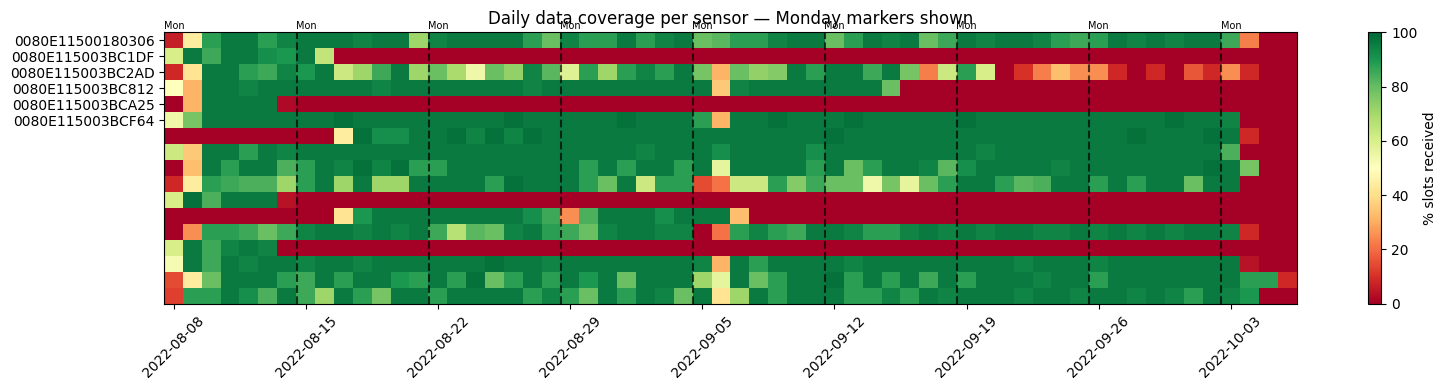

In [357]:
df[df['sensor_ID'] == '0080E115003BC1DF']   
df['date'] = df['timestamp'].dt.date 
df['hour'] = df['timestamp'].dt.hour 
df['slot'] = df['timestamp'].dt.hour * 2 + df['timestamp'].dt.minute // 30 # data is sampled every 15/30 minutes
df[['timestamp','date','hour','slot']]


n_expected = 48 # slots per day 
week_start = pd.Timestamp('2022-06-10')
week_end   = week_start + pd.Timedelta(days=7)

coverage = ( #
    df.groupby(['date', 'sensor_ID'])['slot']
    .count()
    .unstack(level='sensor_ID')   # shape: (days, sensors)
    .fillna(0)
)

sensors = reliable_sensors
dates = pd.to_datetime(list(coverage.index))   # ensure datetime for weekday check

# ── 3. Full coverage heatmap with Monday bars ─────────────────────────────────
fig, ax = plt.subplots(figsize=(16, 4))
im = ax.imshow(coverage.T / n_expected * 100,
               aspect='auto', cmap='RdYlGn', vmin=0, vmax=100)

# Draw vertical bar at every Monday
for i, d in enumerate(dates):
    if d.weekday() == 0:   # Monday
        ax.axvline(x=i - 0.5, color='black', linewidth=1.5, linestyle='--', alpha=0.7)
        ax.text(i, -0.7, 'Mon', fontsize=7, ha='center', color='black')

ax.set_yticks(range(len(sensors)))
ax.set_yticklabels(sensors)
ax.set_xticks(range(0, len(dates), 7))
ax.set_xticklabels([str(d.date()) for d in dates[::7]], rotation=45)
plt.colorbar(im, ax=ax, label='% slots received')
ax.set_title('Daily data coverage per sensor — Monday markers shown')
plt.tight_layout(); plt.show()


start_date   end_date  mean_coverage  min_coverage  all_present  full_week  score
2022-08-22 2022-08-28          0.705           0.0        False      False  0.352
2022-08-29 2022-09-04          0.698           0.0        False      False  0.349
2022-08-15 2022-08-21          0.676           0.0        False      False  0.338
2022-08-08 2022-08-14          0.666           0.0        False      False  0.333
2022-09-12 2022-09-18          0.612           0.0        False      False  0.306
2022-09-05 2022-09-11          0.602           0.0        False      False  0.301
2022-09-19 2022-09-25          0.577           0.0        False      False  0.288
2022-09-26 2022-10-02          0.564           0.0        False      False  0.282

✅ Best week: 2022-08-22 (Mon) → 2022-08-28 (Sun)
   mean coverage : 70.5%
   min  coverage : 0.0%
   fully clean   : False


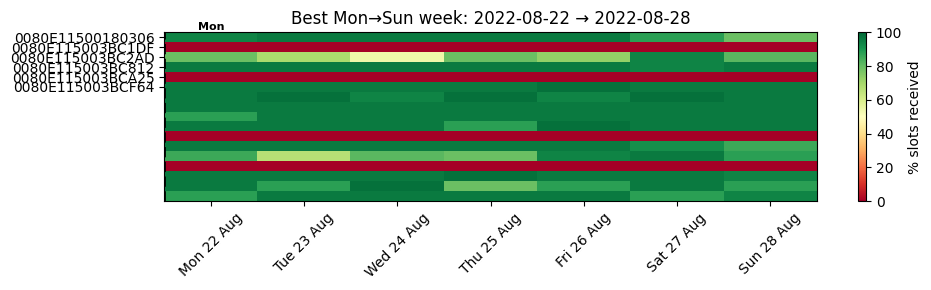

In [358]:
# ── 4. Score only Mon→Sun windows ────────────────────────────────────────────
coverage_arr = coverage.values
week_scores  = []

for i, d in enumerate(dates):
    if d.weekday() != 0:          # only start on Mondays
        continue
    if i + 7 > len(dates):        # not enough days left
        continue

    block        = coverage_arr[i:i+7]
    completeness = (block / n_expected).clip(0, 1)

    week_scores.append({
        'start_date'    : dates[i].date(),
        'end_date'      : dates[i + 6].date(),
        'mean_coverage' : round(completeness.mean(), 3),
        'min_coverage'  : round(completeness.min(), 3),
        'all_present'   : (completeness > 0).all(),
        'full_week'     : (completeness >= 0.9).all(),
        'score'         : round(completeness.mean() * 0.5 + completeness.min() * 0.5, 3)
    })

weeks_df = pd.DataFrame(week_scores).sort_values('score', ascending=False)
print(weeks_df.to_string(index=False))

# ── 5. Best Mon→Sun week ──────────────────────────────────────────────────────
best       = weeks_df.iloc[0]
week_start = pd.Timestamp(best['start_date'])
week_end   = week_start + pd.Timedelta(days=7)   # exclusive upper bound

print(f"\n✅ Best week: {best['start_date']} (Mon) → {best['end_date']} (Sun)")
print(f"   mean coverage : {best['mean_coverage']*100:.1f}%")
print(f"   min  coverage : {best['min_coverage']*100:.1f}%")
print(f"   fully clean   : {best['full_week']}")

# ── 6. Zoom heatmap on best week with Monday bar ──────────────────────────────
best_mask  = (coverage.index >= best['start_date']) & (coverage.index <= best['end_date'])
best_block = coverage.loc[best_mask]
best_dates = pd.to_datetime(list(best_block.index))

fig, ax = plt.subplots(figsize=(10, 3))
im = ax.imshow(best_block.T / n_expected * 100,
               aspect='auto', cmap='RdYlGn', vmin=0, vmax=100)

# Monday bar on zoom plot (should be slot 0)
for i, d in enumerate(best_dates):
    if d.weekday() == 0:
        ax.axvline(x=i - 0.5, color='black', linewidth=2, linestyle='--')
        ax.text(i, -0.7, 'Mon', fontsize=8, ha='center', fontweight='bold')

ax.set_yticks(range(len(sensors)))
ax.set_yticklabels(sensors)
ax.set_xticks(range(7))
ax.set_xticklabels([f"{d.strftime('%a %d %b')}" for d in best_dates], rotation=45)
plt.colorbar(im, ax=ax, label='% slots received')
ax.set_title(f'Best Mon→Sun week: {best["start_date"]} → {best["end_date"]}')
plt.tight_layout(); plt.show()



In [359]:
import numpy as np 

In [360]:
df

week_df = df[(df['timestamp'] >= week_start) & (df['timestamp'] < week_end)].copy()

week_df['sensor_ID'].value_counts()

sensor_ID
0080E115003BC2AD    323
0080E115003BC1DF    323
0080E115003BCF64    322
0080E115003BC812    322
0080E11500180306    321
0080E115003BC996    319
0080E115003BC8D7    318
0080E115003BCA25    315
0080E115003BE631    313
0080E1150017A139    309
0080E115003BDA59    303
0080E115003BCA55    283
0080E1150017F5F8    254
Name: count, dtype: int64

In [361]:
week_df = df[(df['timestamp'] >= week_start) & (df['timestamp'] < week_end)].copy()

features   = ['temperature', 'humidity', 'noise', '% occupancy']
sensors    = sorted(week_df['sensor_ID'].unique())

# week_df[week_df['sensor_ID'] == '0080E115003BC2AD']['slot'].value_counts()

In [362]:
# ── 7. Extract for Tucker3 ────────────────────────────────────────────────────
week_df = df[(df['timestamp'] >= week_start) & (df['timestamp'] < week_end)].copy()

features   = ['temperature', 'humidity', 'noise', '% occupancy']
sensors    = sorted(week_df['sensor_ID'].unique())
n_features = len(features)
n_slots    = 7 * 48   # 336 slots for one week

MISSING_THRESHOLD = 0.90   # drop sensor if more than 75% slots missing


# ── 2. Reindex each sensor to the full index — expose all gaps as NaN ─────────
# ── 2. Build slot-based reindex — robust to timestamp misalignment ────────────

week_df['day_idx']        = (week_df['timestamp'].dt.date.apply(lambda d: (pd.Timestamp(d) - week_start).days))
week_df['slot_in_day']    = (week_df['timestamp'].dt.hour * 2  + week_df['timestamp'].dt.minute // 30)
week_df['global_slot']    = week_df['day_idx'] * 48 + week_df['slot_in_day']
full_slots  = pd.RangeIndex(n_slots)          # 0 … 335
full_index  = pd.date_range(start=week_start, periods=n_slots, freq='30min')

sensor_dfs = {}
for sid in sensors:
    s = week_df[week_df['sensor_ID'] == sid].copy()
    s_agg = (
        s.groupby('global_slot')[features]
         .mean()
    )

    s_reindexed = s_agg.reindex(full_slots)
    s_reindexed.index = full_index
    sensor_dfs[sid] = s_reindexed
    
# ── 3. Report missingness + drop unreliable sensors ──────────────────────────
print("=" * 55)
print(f"  Missingness report  (threshold: >{MISSING_THRESHOLD*100:.0f}% → dropped)")
print("=" * 55)

dropped_sensors  = []
reliable_sensors = []

for sid, s in sensor_dfs.items():
    n_missing = s.isnull().any(axis=1).sum()
    pct       = n_missing / n_slots

    status = ""
    if pct > MISSING_THRESHOLD:
        dropped_sensors.append(sid)
        status = (
            f"  ⚠️  DROPPED  — sensor '{sid}' has {pct*100:.1f}% missing data "
            f"({n_missing}/{n_slots} slots).\n"
            f"     This sensor is considered UNRELIABLE for this week:\n"
            f"     it failed to transmit data for more than {MISSING_THRESHOLD*100:.0f}% "
            f"of the expected time window.\n"
            f"     Possible causes: hardware fault, power loss, connectivity failure,\n"
            f"     or physical damage. Excluding from Tucker3 decomposition."
        )
        print(status)
    else:
        reliable_sensors.append(sid)
        flag = "✅" if pct < 0.1 else "🟡"
        print(f"  {flag} KEPT     — sensor '{sid}' : "
              f"{n_missing:3d} missing slots ({pct*100:.1f}%)")

print("=" * 55)
print(f"  Kept   : {len(reliable_sensors)} sensors → {reliable_sensors}")
print(f"  Dropped: {len(dropped_sensors)} sensors → {dropped_sensors}")
print("=" * 55)

if len(reliable_sensors) == 0:
    raise ValueError(
        "All sensors were dropped for this week — "
        "choose a different week or lower the threshold."
    )

# ── 4. Keep only reliable sensors from here on ───────────────────────────────
sensor_dfs = {sid: sensor_dfs[sid] for sid in reliable_sensors}
n_sensors  = len(reliable_sensors)

# ── 5. Fill missing values with 0 (no data = no activity/signal) ──────────────
def fill_sensor(s, full_index):
    s = s.copy()

    # identify which slots are missing before filling
    missing_mask = s.isnull().any(axis=1)
    n_missing    = missing_mask.sum()

    if n_missing > 0:
        # per-feature fill value — adjust to domain logic if needed
        fill_values = {
            'temperature'  :  -1,   # -1 = sensor off, physically distinct from 0°C
            'humidity'     :  -1,   # 0% is edge-of-range, signals no reading
            'noise'        :  -1,   # 0 dB = silence / no reading
            '% occupancy'  :  -1,   # 0% = no one sitting, safe neutral value
        }

        for feat in features:
            fv = fill_values.get(feat, 0)   # default to 0 for unknown features
            s[feat] = s[feat].fillna(fv)

        print(f"    → {n_missing} missing slots filled "
              f"(temperature→-1, others→0)")
    else:
        print(f"    → no missing slots")

    return s

sensor_dfs_filled = {}
print("\nFilling missing slots:")
for sid, s in sensor_dfs.items():
    print(f"  sensor '{sid}'")
    sensor_dfs_filled[sid] = fill_sensor(s, full_index)

# ── 6. Verify — no NaNs should remain ────────────────────────────────────────
# print("\nNaNs remaining after fill:")
# for sid, s in sensor_dfs_filled.items():
#     n_nan = s.isnull().sum().sum()
#     print(f"  {sid} : {n_nan} NaNs {'✅' if n_nan == 0 else '❌ CHECK'}")

# ── 7. Build tensor (sensors × features × slots) ─────────────────────────────
X = np.zeros((n_sensors, n_features, n_slots))

for i, sid in enumerate(reliable_sensors):
    for j, feat in enumerate(features):
        X[i, j, :] = sensor_dfs_filled[sid][feat].values

print(f"\nTensor shape   : {X.shape}  →  "
      f"({n_sensors} sensors × {n_features} features × {n_slots} slots)")
print(f"Any NaN in X   : {np.isnan(X).any()}")
print(f"Any Inf in X   : {np.isinf(X).any()}")

  Missingness report  (threshold: >90% → dropped)
  ✅ KEPT     — sensor '0080E1150017A139' :  27 missing slots (8.0%)
  🟡 KEPT     — sensor '0080E1150017F5F8' :  82 missing slots (24.4%)
  ✅ KEPT     — sensor '0080E11500180306' :  15 missing slots (4.5%)
  ✅ KEPT     — sensor '0080E115003BC1DF' :  13 missing slots (3.9%)
  ✅ KEPT     — sensor '0080E115003BC2AD' :  13 missing slots (3.9%)
  ✅ KEPT     — sensor '0080E115003BC812' :  14 missing slots (4.2%)
  ✅ KEPT     — sensor '0080E115003BC8D7' :  18 missing slots (5.4%)
  ✅ KEPT     — sensor '0080E115003BC996' :  17 missing slots (5.1%)
  ✅ KEPT     — sensor '0080E115003BCA25' :  21 missing slots (6.2%)
  🟡 KEPT     — sensor '0080E115003BCA55' :  53 missing slots (15.8%)
  ✅ KEPT     — sensor '0080E115003BCF64' :  14 missing slots (4.2%)
  ✅ KEPT     — sensor '0080E115003BDA59' :  33 missing slots (9.8%)
  ✅ KEPT     — sensor '0080E115003BE631' :  23 missing slots (6.8%)
  Kept   : 13 sensors → ['0080E1150017A139', '0080E1150017F5F8',

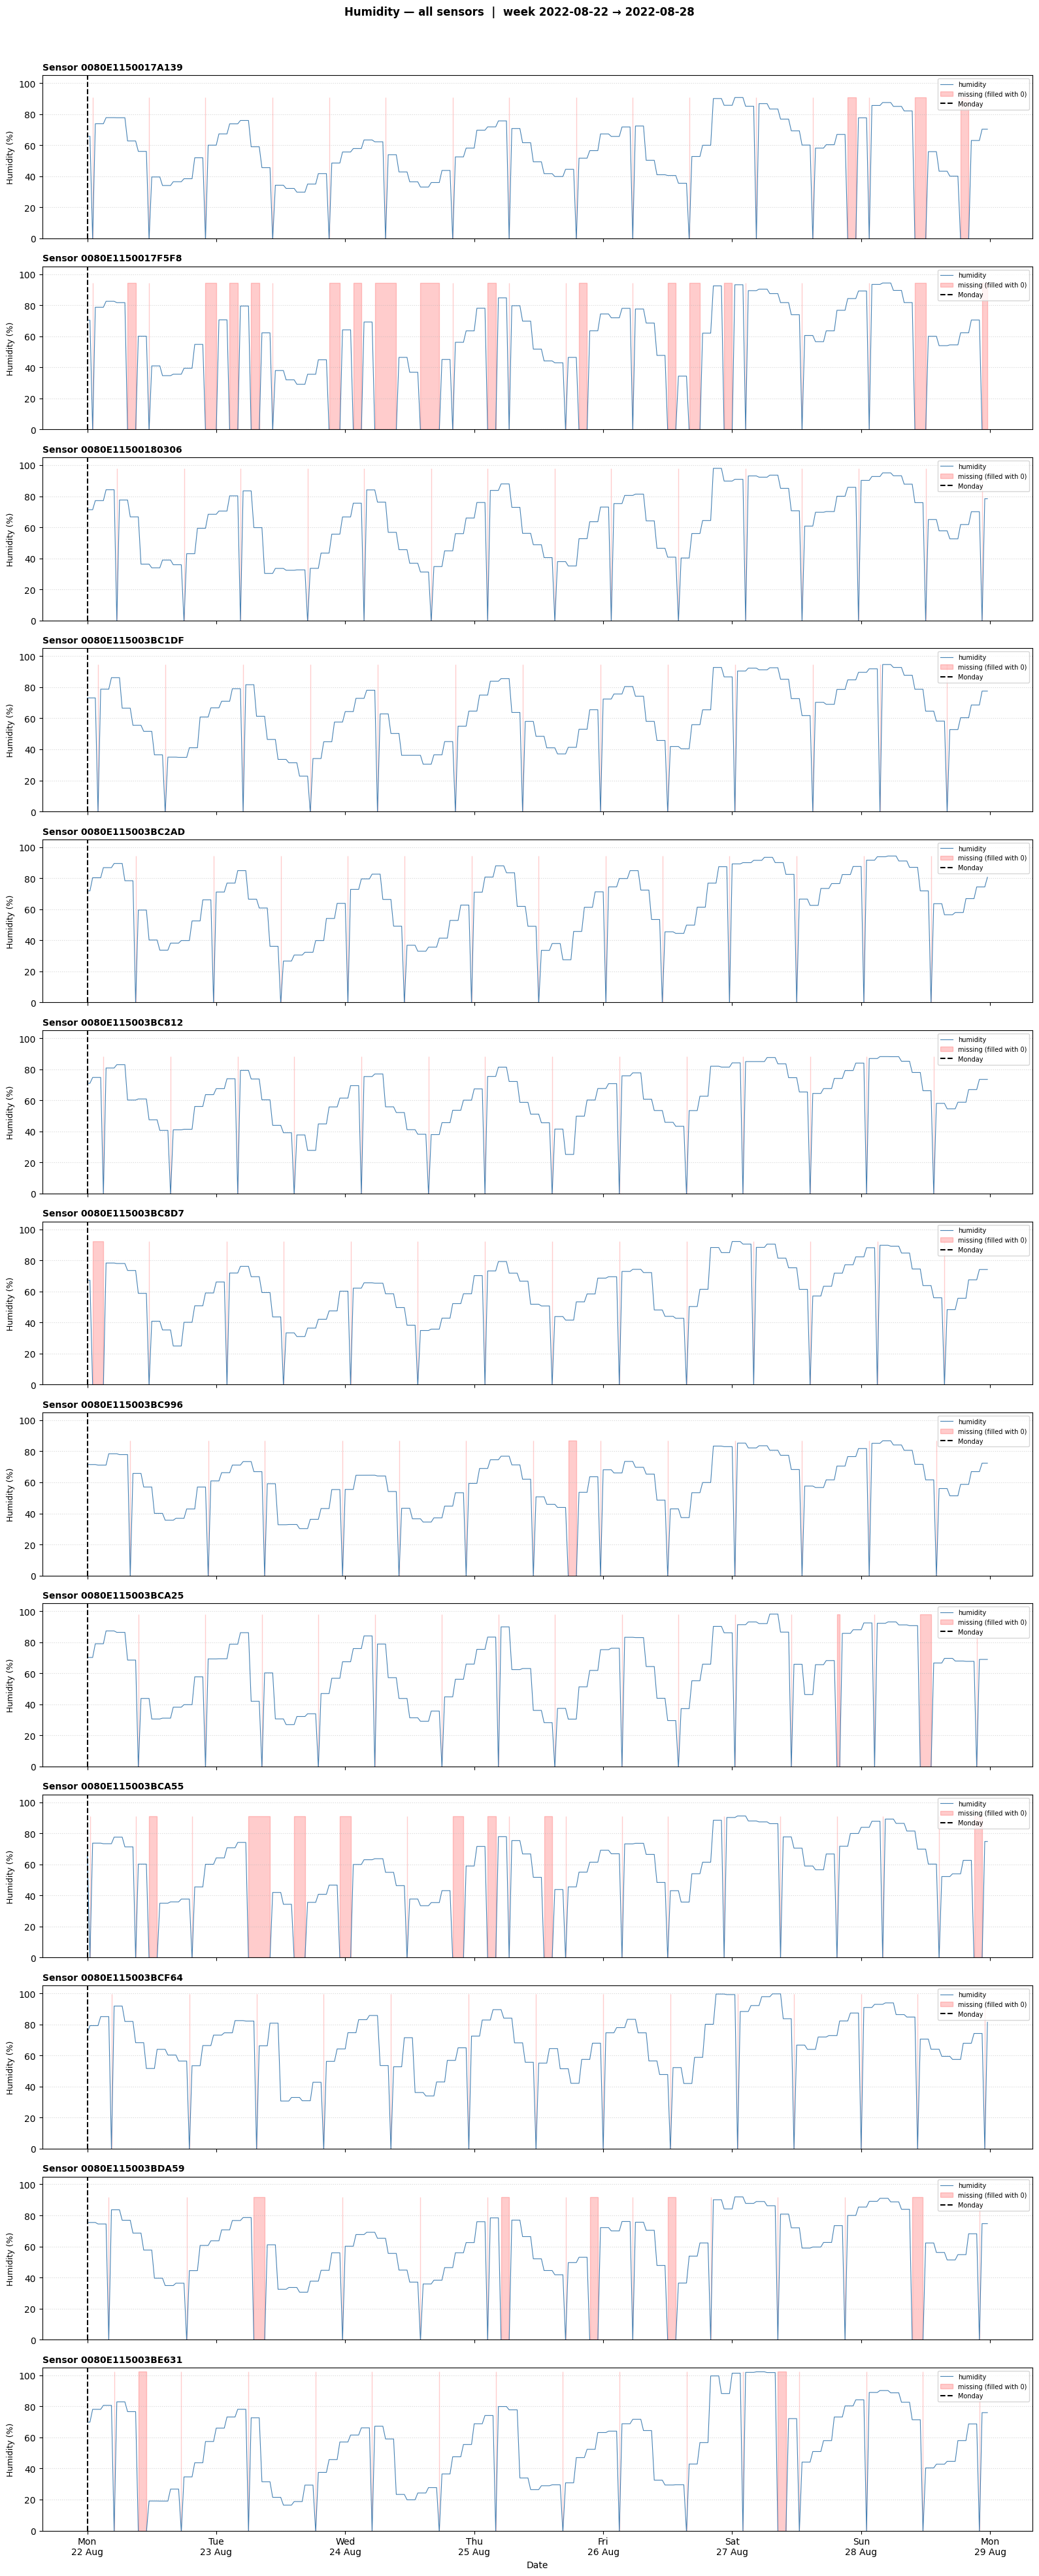

In [363]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(n_sensors, 1, figsize=(16, 3 * n_sensors), sharex=True)

# handle case of single sensor
if n_sensors == 1:
    axes = [axes]

for ax, sid in zip(axes, reliable_sensors):
    s             = sensor_dfs_filled[sid]
    humidity      = s['humidity']
    missing_mask  = sensor_dfs[sid]['humidity'].isnull()   # original gaps before fill

    ax.plot(full_index, humidity, color='steelblue', linewidth=0.8, label='humidity')
    ax.fill_between(full_index, 0, humidity.max(),
                    where=missing_mask,
                    color='red', alpha=0.2, label='missing (filled with 0)')
    for ts in full_index:
        if ts.weekday() == 0 and ts.hour == 0 and ts.minute == 0:
            ax.axvline(ts, color='black', linewidth=1.5,
                       linestyle='--', label='Monday' if ts == full_index[0] else '')
    ax.set_ylabel('Humidity (%)', fontsize=9)
    ax.set_title(f'Sensor {sid}', fontsize=10, fontweight='bold', loc='left')
    ax.set_ylim(0, 105)
    ax.yaxis.grid(True, linestyle=':', alpha=0.5)
    ax.legend(loc='upper right', fontsize=7)

axes[-1].set_xlabel('Date')
axes[-1].xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())
axes[-1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%a\n%d %b'))

fig.suptitle(f'Humidity — all sensors  |  week {week_start.date()} → '
             f'{(week_start + pd.Timedelta(days=6)).date()}',
             fontsize=12, fontweight='bold', y=1.01)

plt.tight_layout()
plt.show()

- only two locations are available **vulkan platz** and **munsterhof**

In [364]:
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.metrics import adjusted_rand_score, silhouette_score,confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler


sensor_coords = (week_df.groupby('sensor_ID')[['latitude','longitude']]
                    .mean()
                    .reset_index() 
                    )
coords = sensor_coords[['latitude','longitude']].values
N_clusters = 2 

coords_scaled = StandardScaler().fit_transform(coords)
kmeans = KMeans(n_clusters=N_clusters,random_state=42,init='k-means++')
sensor_coords['cluster_kmeans'] = kmeans.fit_predict(coords_scaled) * 50
sensor_coords['cluster_kmeans'].value_counts()
import plotly.express as px

# df2 = df[df['sit'] > 60]
fig = px.scatter_map(
    sensor_coords,
    lat="latitude",
    lon="longitude",
    color='cluster_kmeans',
    range_color=[0, 100], 
    zoom=12,
    height=500,
)
fig.update_layout(mapbox_style="open-street-map")

scale_lon_start = sensor_coords['longitude'].min() + 0.01
scale_lon_end = scale_lon_start + 0.01  # roughly ~1 km depending on latitude
scale_lat = sensor_coords['latitude'].min() + 0.01

fig.add_shape(
    type="line",
    x0=scale_lon_start,
    y0=scale_lat,
    x1=scale_lon_end,
    y1=scale_lat,
    line=dict(color="black", width=4),
    xref="x",
    yref="y"
)

# Add text annotation for the scale
fig.add_annotation(
    x=(scale_lon_start + scale_lon_end)/2,
    y=scale_lat + 0.002,  # slightly above line
    text="~1 km",
    showarrow=False,
    font=dict(color="black", size=12),
    xref="x",
    yref="y"
)

fig.show()

In [365]:
# # when we want to feed the Tucker3 only with a group

# sensor_to_cluster = sensor_coords[sensor_coords['sensor_ID'].isin(reliable_sensors)].set_index('sensor_ID')['cluster_kmeans'].to_dict()
# cluster0_sensors = [sid for sid , cl in sensor_to_cluster.items() if cl == 0]
# cluster0_indices = [reliable_sensors.index(sid) for sid in cluster0_sensors]
# reliable_sensors = cluster0_sensors
# X_0 = X[cluster0_indices,:,:]

# Pre-processing

In [366]:
from sklearn.preprocessing import StandardScaler 

N_sensors, N_features, N_slots = X.shape

X_2d      = X.reshape(-1, N_features)          # (n_sensors*n_slots, n_features)
scaler    = StandardScaler()
X_2d_scaled = scaler.fit_transform(X_2d)

X_scaled  = X_2d_scaled.reshape(N_sensors, N_features, N_slots)
# X_scaled = X

# Sanity Check group variance

In [367]:
# # Compare eigenvalues between the two Tucker decompositions
# _, s_both, _ = np.linalg.svd(X_scaled.reshape(X_scaled.shape[0], -1))
# _, s_c0,   _ = np.linalg.svd(X_0.reshape(X_0.shape[0], -1))

# print("Top eigenvalues — both clusters:", s_both[:4].round(2))
# print("Top eigenvalues — cluster 0:    ", s_c0[:4].round(2))

# # You will see s_both >> s_c0
# # confirming that between-cluster variance was inflating eigenvalues

# new information

In [368]:
%load_ext autoreload 
%autoreload 2 
from tucker3 import Tucker3

model = Tucker3(LowRankApprox=np.array([3,3,3]), maxIter=100, tolCriteria=0.02,ErrorScaled=True)

# TODO error with scaling not being updated correctly ...
results             = model.fit_transform(X_scaled,verbose=False)
_, XT_scaled, _     = model.transform(X_scaled,verbose=True)
metrics             = model.calcContribution(XT_scaled)

A = results['scores']
B = results['varLoadings']
C = results['timeLoadings']
F = results['coreTensor'] 

HT2             = model.calcIMD(input=X_scaled,metric="HotellingT2").reshape(N_sensors,1)
DModX           = model.calcOOMD(input=X_scaled,metric="DModX").reshape(N_sensors,1)

df_out          = pd.DataFrame(np.hstack((HT2,DModX)),columns=("HT2","DModX"),index=reliable_sensors)
df_out['T_SPE'] = metrics['T_SPE']
df_out['TSQR']  = metrics['TSQR']
new_cols        = [f"con_TSQR_{feat}" for feat in FEATURES]
df_out[new_cols]= metrics['con_TSQR']
df_iSPE         = pd.DataFrame(metrics['iSPE_batch'],columns=FEATURES,index=reliable_sensors)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [370]:
from scipy.stats import chi2

# recompute threshold for each decomposition separately
k         = 3              # number of sensor components
threshold = chi2.ppf(0.95, df=k)

# normalize scores within each decomposition before computing T²R
scores    = A / A.std(axis=0)    # A from that specific Tucker run
T2R       = np.sum(scores**2, axis=1)

print(f"T²R threshold (χ² 95%, df={k}): {threshold:.2f}")
print(f"T²R values: {T2R.round(2)}")

T²R threshold (χ² 95%, df=3): 7.81
T²R values: [456.07 541.68 489.9  471.89 508.2  508.14 408.2  437.45 502.83 498.53
 505.38 476.23 376.08]


In [340]:
df_out['TSQR']

0080E1150017A139    483.059992
0080E1150017F5F8    522.919215
0080E11500180306    533.674287
0080E115003BC1DF    518.027179
0080E115003BC2AD    558.546964
0080E115003BC812    557.796090
0080E115003BC8D7    449.024700
0080E115003BC996    476.615110
0080E115003BCA25    548.527413
0080E115003BCA55    532.462159
0080E115003BCF64    552.866854
0080E115003BDA59    506.301277
0080E115003BE631    413.910563
Name: TSQR, dtype: float64

In [341]:
df_out['LV1'] = results['scores'][:,0]
for i in range(results['scores'].shape[1] - 1):
    df_out[f'LV{i+2}'] = results['scores'][:,i+1]


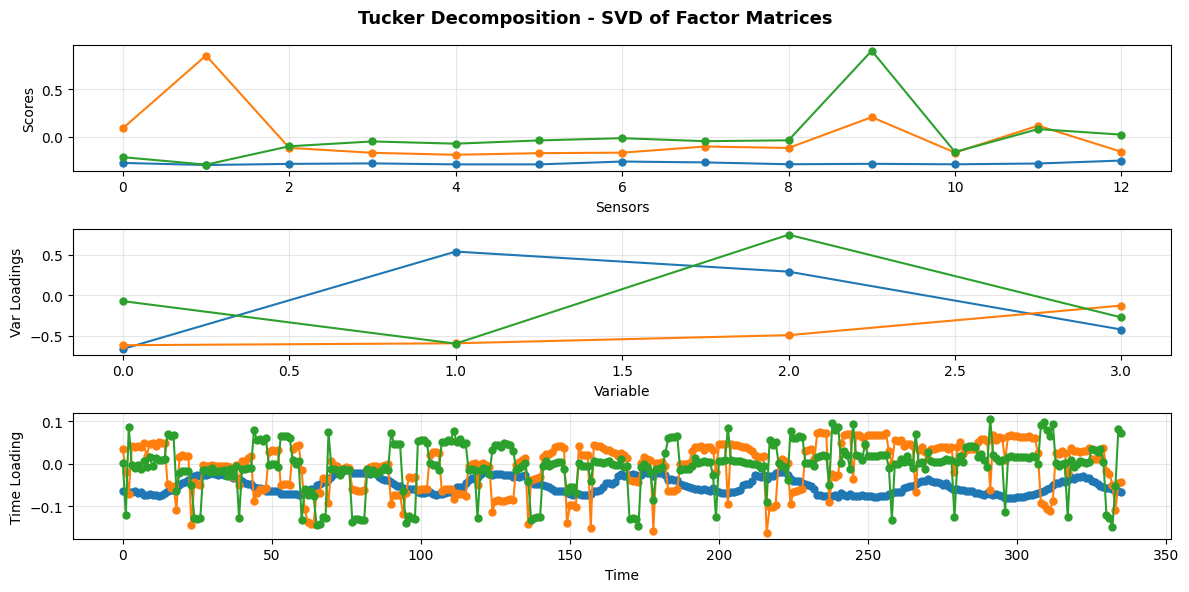

In [342]:
fig, axes = plt.subplots( 3,1, figsize=(12,6))


axes[0].plot(A,'o-',linewidth=1.5,markersize=5)
axes[0].set_xlabel('Sensors')
axes[0].set_ylabel('Scores')
axes[0].grid(True,alpha=0.3)

axes[1].plot(B,'o-',linewidth=1.5,markersize=5)
axes[1].set_xlabel('Variable')
axes[1].set_ylabel('Var Loadings')
axes[1].grid(True,alpha=0.3)

axes[2].plot(C,'o-',linewidth=1.5,markersize=5)
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Time Loading")
axes[2].grid(True, alpha=0.3)


fig.suptitle('Tucker Decomposition - SVD of Factor Matrices', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

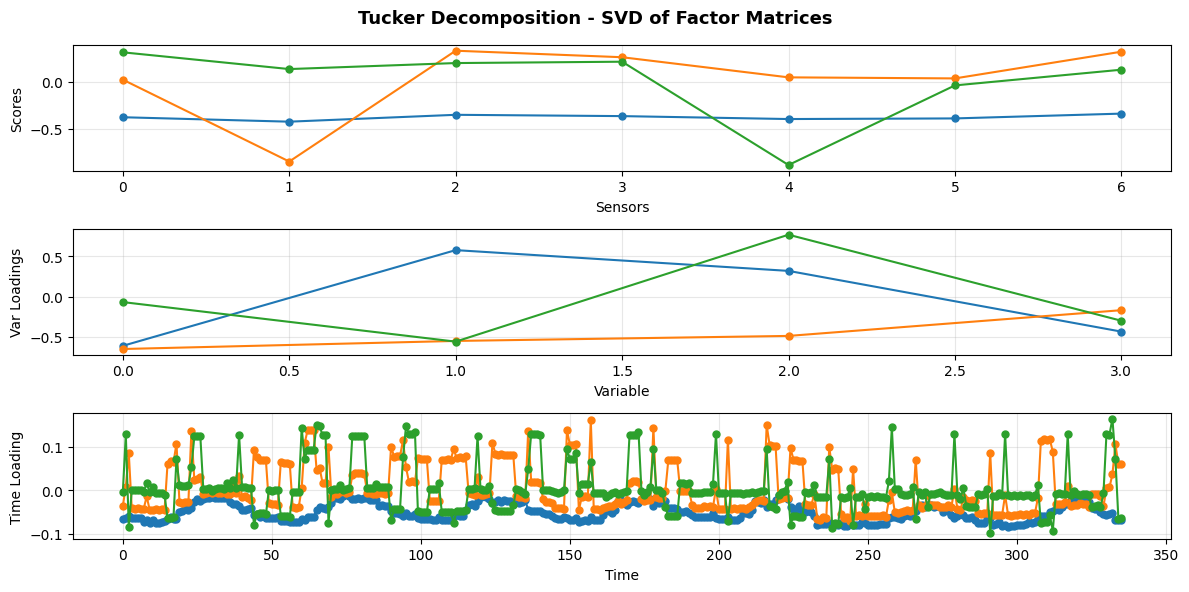

In [325]:
fig, axes = plt.subplots( 3,1, figsize=(12,6))


axes[0].plot(A,'o-',linewidth=1.5,markersize=5)
axes[0].set_xlabel('Sensors')
axes[0].set_ylabel('Scores')
axes[0].grid(True,alpha=0.3)

axes[1].plot(B,'o-',linewidth=1.5,markersize=5)
axes[1].set_xlabel('Variable')
axes[1].set_ylabel('Var Loadings')
axes[1].grid(True,alpha=0.3)

axes[2].plot(C,'o-',linewidth=1.5,markersize=5)
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Time Loading")
axes[2].grid(True, alpha=0.3)


fig.suptitle('Tucker Decomposition - SVD of Factor Matrices', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

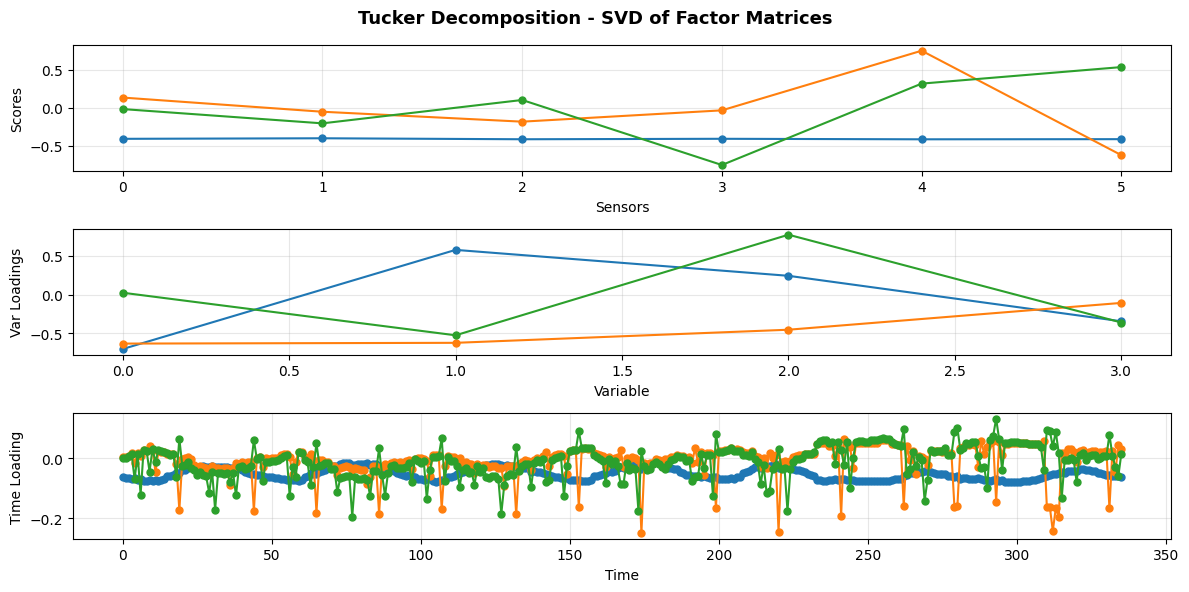

In [301]:
fig, axes = plt.subplots( 3,1, figsize=(12,6))


axes[0].plot(A,'o-',linewidth=1.5,markersize=5)
axes[0].set_xlabel('Sensors')
axes[0].set_ylabel('Scores')
axes[0].grid(True,alpha=0.3)

axes[1].plot(B,'o-',linewidth=1.5,markersize=5)
axes[1].set_xlabel('Variable')
axes[1].set_ylabel('Var Loadings')
axes[1].grid(True,alpha=0.3)

axes[2].plot(C,'o-',linewidth=1.5,markersize=5)
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Time Loading")
axes[2].grid(True, alpha=0.3)


fig.suptitle('Tucker Decomposition - SVD of Factor Matrices', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

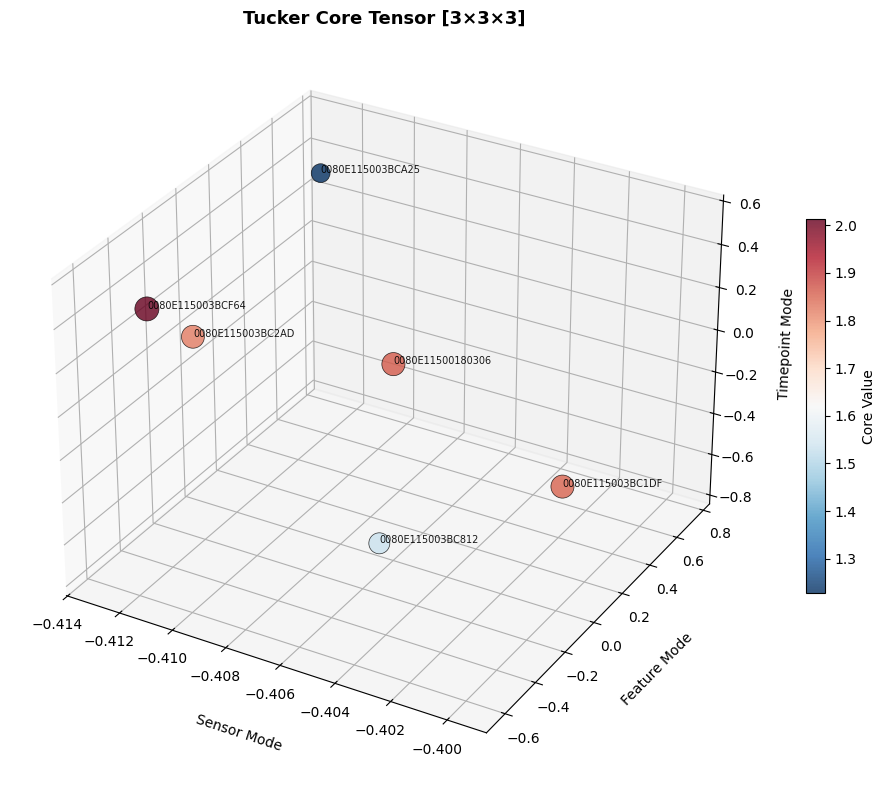

In [302]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x, y, z = np.meshgrid(3,3,3, indexing='ij')
values = F.numpy() if hasattr(F, 'numpy') else np.array(F)

x = df_out['LV1']
y = df_out['LV2']
z = df_out['LV3']
v = df_out['DModX']
labels = df_out.index.astype(str).to_numpy()

sc = ax.scatter(x, y, z,
                c=v,
                s=np.abs(v) / np.abs(v).max() * 300,
                cmap='RdBu_r',
                alpha=0.8,
                edgecolors='k',
                linewidths=0.5)

for i, (xi, yi, zi, vi) in enumerate(zip(x, y, z, labels)):
    ax.text(xi, yi, zi, vi, fontsize=7, alpha=0.9)

plt.colorbar(sc, ax=ax, label='Core Value', shrink=0.5)

ax.set_xlabel('Sensor Mode', labelpad=15)
ax.set_ylabel('Feature Mode', labelpad=15)
ax.set_zlabel('Timepoint Mode', labelpad=10)
ax.set_title('Tucker Core Tensor [3×3×3]', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

C:\Users\tudor\AppData\Local\Temp\ipykernel_27912\4148721168.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\tudor\AppData\Local\Temp\ipykernel_27912\4148721168.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\tudor\AppData\Local\Temp\ipykernel_27912\4148721168.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\tudor\AppData\Local\Temp\ipykernel_27912\4148721168.py:18: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\tudor\AppData\Local\Temp\ipykernel_27912\4148721168.py:27: FutureWarning:



Passing `pale

[Text(0, 0, 'con_TSQR_humidity'),
 Text(1, 0, 'con_TSQR_noise'),
 Text(2, 0, 'con_TSQR_temperature'),
 Text(3, 0, 'con_TSQR_% occupancy')]

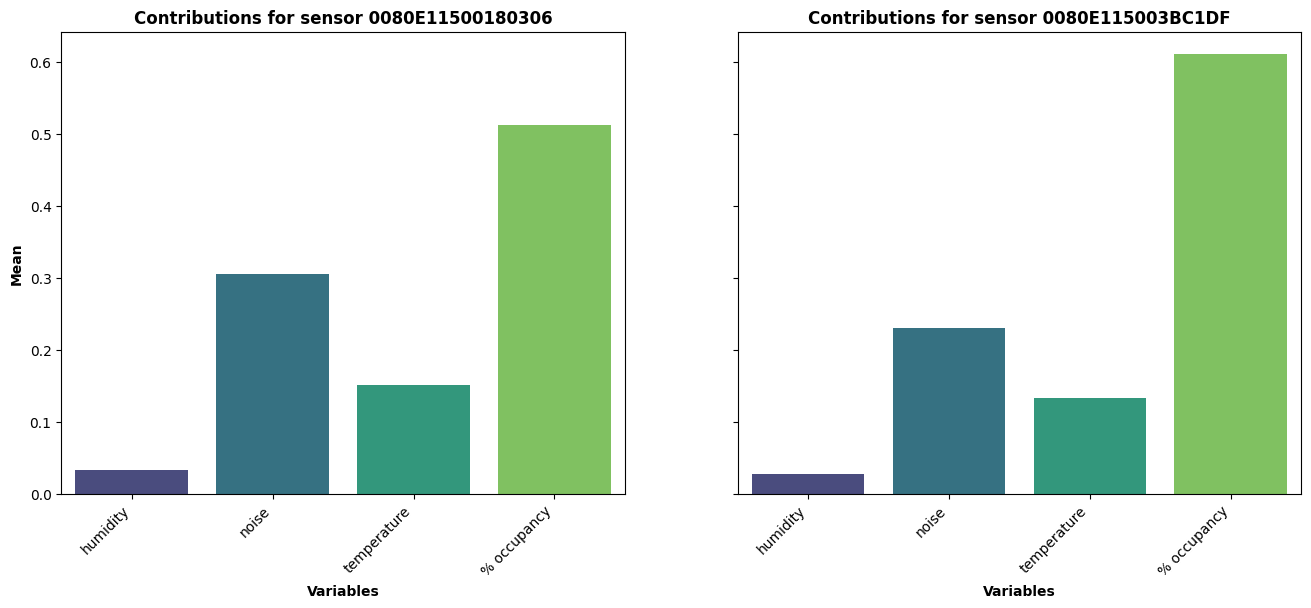

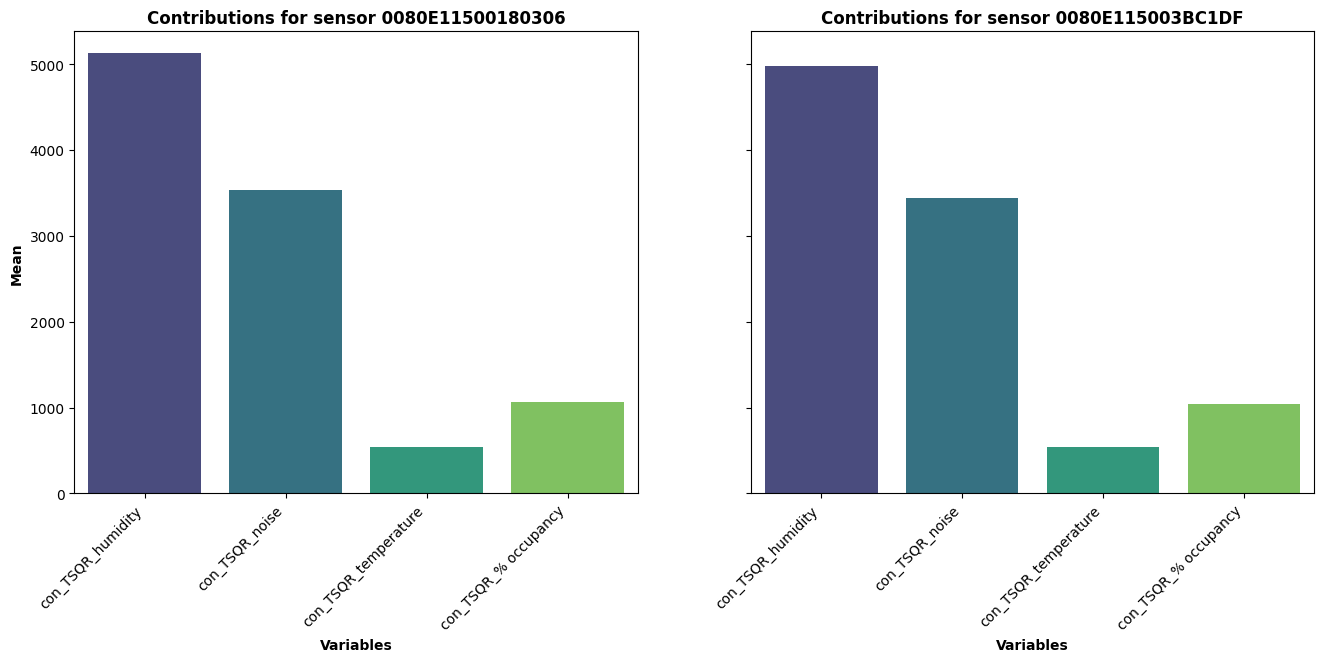

In [303]:
import seaborn as sns 
sensor1 = reliable_sensors[0]
sensor2 = reliable_sensors[1]
df_iSPE1 = df_iSPE.loc[sensor1]
df_iSPE2 = df_iSPE.loc[sensor2]

fig, axes = plt.subplots(1,2, figsize=(16,6), sharey=True)
sns.barplot(data=df_iSPE1,palette='viridis',ax=axes[0])
axes[0].set_xlabel('Variables',fontweight='bold')
axes[0].set_ylabel('Mean',fontweight='bold')
axes[0].set_title(f'Contributions for sensor {sensor1}',fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45,ha='right')

sns.barplot(data=df_iSPE2,palette='viridis',ax=axes[1])
axes[1].set_xlabel('Variables',fontweight='bold')
axes[1].set_ylabel('Mean',fontweight='bold')
axes[1].set_title(f'Contributions for sensor {sensor2}',fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45,ha='right')


import seaborn as sns 
new_cols        = [f"con_TSQR_{feat}" for feat in FEATURES]
df_iSPE1 = df_out.loc[sensor1,new_cols]
df_iSPE2 = df_out.loc[sensor2,new_cols]

fig, axes = plt.subplots(1,2, figsize=(16,6), sharey=True)
sns.barplot(data=df_iSPE1,palette='viridis',ax=axes[0])
axes[0].set_xlabel('Variables',fontweight='bold')
axes[0].set_ylabel('Mean',fontweight='bold')
axes[0].set_title(f'Contributions for sensor {sensor1}',fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45,ha='right')

sns.barplot(data=df_iSPE2,palette='viridis',ax=axes[1])
axes[1].set_xlabel('Variables',fontweight='bold')
axes[1].set_ylabel('Mean',fontweight='bold')
axes[1].set_title(f'Contributions for sensor {sensor2}',fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45,ha='right')


In [304]:
import matplotlib.patches as mpatches 
from scipy.stats import chi2 

def ellipse_confidence(df,x_col='TSQR',y_col='DModX',confidence=0.95,facecolor='none',edgecolor='darkred'):
    x_all = df[x_col].to_numpy()
    y_all = df[y_col].to_numpy()

    xy = np.column_stack((x_all,y_all))
    mu  = xy.mean(axis=0)
    cov = np.cov(xy,rowvar=False)

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    chi2_q = chi2.ppf(confidence,df=2)
    width = 2. * np.sqrt(eigvals[0] * chi2_q)
    height = 2. * np.sqrt(eigvals[1] * chi2_q)

    angle = np.degrees(np.arctan2(eigvecs[1,0], eigvecs[0,0]))
    ell = mpatches.Ellipse(xy=mu,width=width,height=height,angle=angle,facecolor=facecolor,edgecolor=edgecolor,alpha=0.12,zorder=1,linewidth=1.)

    inv_cov = np.linalg.pinv(cov)
    diffs = xy - mu 
    d2 = np.einsum("ij, jk, ik->i",diffs,inv_cov,diffs)
    outside_mask = d2 > chi2_q
    outside_ids = list(df.index.astype(str).to_numpy()[outside_mask])

    return ell, outside_ids

C:\Users\tudor\AppData\Local\Temp\ipykernel_27912\3583318779.py:85: UserWarning:

Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.

C:\Users\tudor\AppData\Local\Temp\ipykernel_27912\3583318779.py:85: UserWarning:

Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.

C:\Users\tudor\AppData\Local\Temp\ipykernel_27912\3583318779.py:85: UserWarning:

Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.

c:\Users\tudor\anaconda3\envs\sensor_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.

c:\Users\tudor\anaconda3\envs\sensor_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.

c:\Users\tudor\anaconda3\envs\sensor_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.



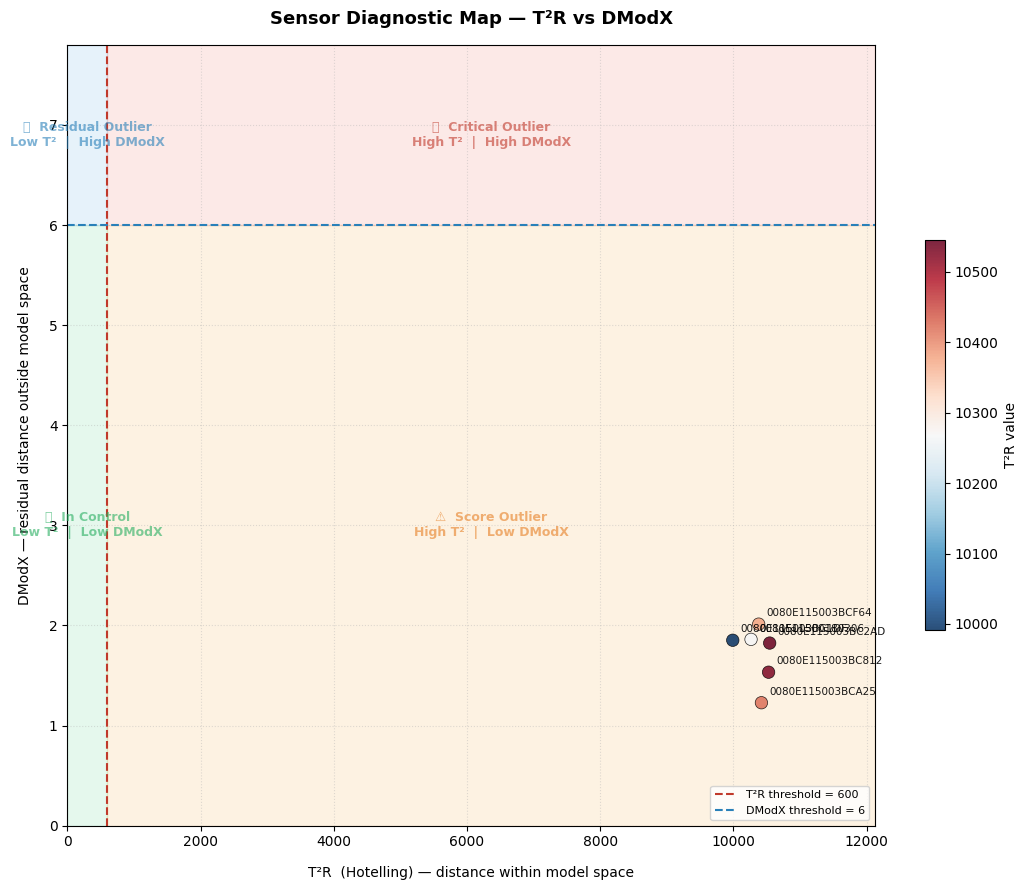

In [305]:
fig = plt.figure(figsize=(11, 9))
ax  = plt.axes()

# ── Thresholds ────────────────────────────────────────────────────────────────
TSQR_THRESH  = 600
DMODX_THRESH = 6

x = df_out['TSQR']
y = df_out['DModX']
v = df_out.index.astype(str).to_numpy()

x_max = max(x.max() * 1.15, TSQR_THRESH  * 1.3)
y_max = max(y.max() * 1.15, DMODX_THRESH * 1.3)

# ── Four quadrant fills ───────────────────────────────────────────────────────
#   Q1 bottom-left  : low T², low DModX  → normal / in control
#   Q2 bottom-right : high T², low DModX → score outlier
#   Q3 top-left     : low T², high DModX → residual outlier
#   Q4 top-right    : high T², high DModX → critical outlier

ax.fill_betweenx([0,             DMODX_THRESH], 0, TSQR_THRESH,
                 color='#2ecc71', alpha=0.12)   # Q1 green
ax.fill_betweenx([0,             DMODX_THRESH], TSQR_THRESH, x_max,
                 color='#f39c12', alpha=0.12)   # Q2 orange
ax.fill_betweenx([DMODX_THRESH, y_max],         0, TSQR_THRESH,
                 color='#3498db', alpha=0.12)   # Q3 blue
ax.fill_betweenx([DMODX_THRESH, y_max],         TSQR_THRESH, x_max,
                 color='#e74c3c', alpha=0.12)   # Q4 red

# ── Threshold lines ───────────────────────────────────────────────────────────
ax.axvline(TSQR_THRESH,  color='#c0392b', linewidth=1.5,
           linestyle='--', label=f'T²R threshold = {TSQR_THRESH}')
ax.axhline(DMODX_THRESH, color='#2980b9', linewidth=1.5,
           linestyle='--', label=f'DModX threshold = {DMODX_THRESH}')

# ── Quadrant labels ───────────────────────────────────────────────────────────
label_cfg = dict(fontsize=9, fontweight='bold', alpha=0.6,
                 ha='center', va='center')

ax.text(TSQR_THRESH * 0.5,  DMODX_THRESH * 0.5,
        '✅  In Control\nLow T²  |  Low DModX',
        color='#27ae60', **label_cfg)

ax.text(TSQR_THRESH + (x_max - TSQR_THRESH) * 0.5, DMODX_THRESH * 0.5,
        '⚠️  Score Outlier\nHigh T²  |  Low DModX',
        color='#e67e22', **label_cfg)

ax.text(TSQR_THRESH * 0.5,  DMODX_THRESH + (y_max - DMODX_THRESH) * 0.5,
        '🔵  Residual Outlier\nLow T²  |  High DModX',
        color='#2980b9', **label_cfg)

ax.text(TSQR_THRESH + (x_max - TSQR_THRESH) * 0.5,
        DMODX_THRESH + (y_max - DMODX_THRESH) * 0.5,
        '🔴  Critical Outlier\nHigh T²  |  High DModX',
        color='#c0392b', **label_cfg)

# ── Scatter ───────────────────────────────────────────────────────────────────
sc = ax.scatter(x, y,
                c=x,
                cmap='RdBu_r',
                alpha=0.85,
                edgecolors='k',
                linewidths=0.5,
                zorder=5,
                s=80)

# ── Sensor labels ─────────────────────────────────────────────────────────────
for xi, yi, vi in zip(x, y, v):
    ax.text(xi + x_max * 0.01, yi + y_max * 0.01, vi,
            fontsize=7.5, alpha=0.9, zorder=6)

# ── Colorbar + labels ─────────────────────────────────────────────────────────
plt.colorbar(sc, ax=ax, label='T²R value', shrink=0.5)

ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)
ax.set_xlabel('T²R  (Hotelling) — distance within model space', labelpad=12)
ax.set_ylabel('DModX — residual distance outside model space',  labelpad=12)
ax.set_title('Sensor Diagnostic Map — T²R vs DModX',
             fontsize=13, fontweight='bold', pad=15)

ax.legend(loc='lower right', fontsize=8, framealpha=0.8)
ax.grid(True, linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()